# Quantum Phase Application (QPA)
We have used QSVT to solve a linear system $A\ket{x} = \ket{b}$ and QAE to write the first amplitude of $\ket{x}$ into a separate register $\ket{a}$. \
To use the extracted value as a cost term in QAOA, we need to exponentiate it: $\ket{a}\mapsto e^{-i\gamma a}\ket{a}$.

In [1]:
# import python libraries
import numpy as np 
import pennylane as qml
import pennylane.templates as qmlt
import matplotlib.pyplot as plt
import math
from itertools import combinations

# import self-written routines
from routines.bin_dec_conversion import bin2dec

To perform $\ket{x_0}\mapsto e^{-i\gamma x_i}\ket{x_0}$, we apply phase gates $P(-\gamma\alpha_i)$.\
Here, $\alpha_i$ correspond to the fractional contributions of each bit: $\alpha_i = 2^{-i}$.

# Define QPA circuit

In [2]:
def qpa(gamma, wires):
    # Compute alphas
    qae_phase_size = len(wires)
    alphas = [2**(-i-1) for i in range(qae_phase_size)]
    for i, wire in enumerate(wires):
        qml.PhaseShift(-gamma*alphas[i], wires=wire)

# Test QPA

In [3]:
# Define test state for QPA
test_state = [1, 0, 1, 1, 0, 0, 1, 1]

bin = "0."
for i in test_state:
    bin = f"{bin}{i}"
print(f"The state {test_state} corresponds to {bin2dec(bin)}")

The state [1, 0, 1, 1, 0, 0, 1, 1] corresponds to 0.69921875


In [4]:
# Define executable circuit function
wires = np.arange(len(test_state)).tolist()

dev = qml.device("default.qubit", wires=wires)
@qml.qnode(dev)
def test_qpa(gamma, test_state):
    for i, bit in enumerate(test_state):
        if bit == 1:
            qml.PauliX(wires=wires[i])
    qpa(gamma, wires)

    return qml.state()

In [5]:
print(qml.draw(test_qpa)(gamma=0.5, test_state=test_state))

0: ──X──────────Rϕ(-0.25)─┤  State
1: ──Rϕ(-0.12)────────────┤  State
2: ──X──────────Rϕ(-0.06)─┤  State
3: ──X──────────Rϕ(-0.03)─┤  State
4: ──Rϕ(-0.02)────────────┤  State
5: ──Rϕ(-0.01)────────────┤  State
6: ──X──────────Rϕ(-0.00)─┤  State
7: ──X──────────Rϕ(-0.00)─┤  State


In [6]:
# set gamma
gamma = np.pi
# define all possible input bitstrings
test_bitstrings = [f"{x:0{len(test_state)}b}" for x in range(2 ** len(test_state))]
test_bitstrings_list = [[int(bit) for bit in bitstring] for bitstring in test_bitstrings]
# gather the amplitudes of the input states after executing QPA
qpa_result = [test_qpa(gamma=gamma, test_state=state)[i] for i, state in enumerate(test_bitstrings_list)]

# calculate the expected amplitudes
test_input = [bin2dec(f"0.{bitstring}") for bitstring in test_bitstrings]
expected_result = [np.exp(-1j*gamma*a) for a in test_input]

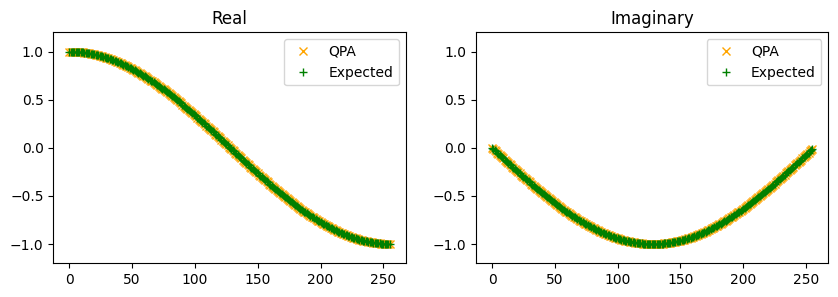

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].set_title("Real")
ax[0].plot(np.real(qpa_result), marker='x', c='orange', label="QPA", ls="")
ax[0].plot(np.real(expected_result), marker='+', c='green', label="Expected", ls="")
ax[0].legend()
ax[0].set_ylim([-1.2, 1.2])

ax[1].set_title("Imaginary")
ax[1].plot(np.imag(qpa_result), marker='x', c='orange', label="QPA", ls="")
ax[1].plot(np.imag(expected_result), marker='+', c='green', label="Expected", ls="")
ax[1].legend()
ax[1].set_ylim([-1.2, 1.2])
plt.show()

The QPA routine yields exactly the solution that we expect!